---
### Libraries and data importation

In [1]:
import pandas as pd
import os
import deepof
import seaborn as sns
import pickle

import matplotlib.pyplot as plt
from networkx import Graph, draw
import deepof.visuals

import deepof.data
from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA

from scipy.stats import ttest_ind

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

In [2]:
DATA = 'supervised_annotation_result4.pkl'
PROJECT = './deepof_projects/deepof_mice5'

In [ ]:
with open(DATA, 'rb') as f:
    data = pickle.load(f)
    
deepof_mice = deepof.data.load_project(PROJECT)

In [ ]:
# 'cageK_astromorph', 'cageI_astromorph'
# 'cageF_astromorph', 'cageJ_astromorph'
to_keep = [ 'cageA_astromorph', 'cageF_astromorph', 'cageH_astromorph', 'cageJ_astromorph', 'cageK_astromorph', 'cageI_astromorph', 'cageD_astromorph']
supervised = {k: data[k] for k in to_keep if k in data}


---
### Useful functions

In [ ]:
def reorganise_data(df):
    '''
    Preprocess the data obtained by deepof 
    '''
    preproc = {}
    mice_speed1 = pd.DataFrame(columns=['cage', 'avg_speed', 'std_speed'])
    mice_speed2 = pd.DataFrame(columns=['cage', 'avg_speed', 'std_speed'])
    
    for key in df.keys():
        time_standardisation = df[key].shape[0]/10000
        
        avg_speed1 = df[key]['individual1_speed'].mean()
        avg_speed2 = df[key]['individual2_speed'].mean()
        std_speed1 = df[key]['individual1_speed'].std()
        std_speed2 = df[key]['individual2_speed'].std()
        
        temp = df[key].drop(columns=['individual1_speed','individual2_speed'])
        row_events = (pd.DataFrame(temp.sum(axis=0)).T)/time_standardisation
        row_events.index = ['number_events']
        event_switch = temp.diff(axis=0)
        event_freq = (pd.DataFrame(event_switch.applymap(lambda x: x if x > 0 else 0).sum()).T)/time_standardisation
        event_freq.index = ['event_freq']

        preproc[key] = pd.concat([row_events, event_freq], axis=0)
        
        mice_speed1 = mice_speed1.append({'cage': key, 'avg_speed': avg_speed1, 'std_speed': std_speed1}, ignore_index=True)
        mice_speed2 = mice_speed2.append({'cage': key, 'avg_speed': avg_speed2, 'std_speed': std_speed2}, ignore_index=True)
        
        mice_speed1['Mouse'] = 'Mouse1'
        mice_speed2['Mouse'] = 'Mouse2'

        mice_speed = pd.concat([mice_speed1, mice_speed2], axis=0)
        
    return preproc, mice_speed


In [ ]:
def process_event_data(combined_data):
    event_freq_dict = {}
    row_events_dict = {}

    for key in combined_data.keys():
        time_standardisation = combined_data[key].shape[0] / 10000

        temp = combined_data[key]#.drop(columns=['individual1_speed', 'individual2_speed'])
        row_events = (pd.DataFrame(temp.sum(axis=0)).T) / time_standardisation
        row_events['cage'] = key
        event_switch = temp.diff(axis=0)
        event_freq = (pd.DataFrame(event_switch.applymap(lambda x: x if x > 0 else 0).sum()).T) / time_standardisation
        event_freq['cage'] = key

        row_events_dict[key] = row_events
        event_freq_dict[key] = event_freq

    row_events_df = pd.concat(row_events_dict, axis=0)
    event_freq_df = pd.concat(event_freq_dict, axis=0)

    return row_events_df, event_freq_df


In [ ]:
def Events_byIndividual(supervised):
    '''
    Return object similar to TableDicts used in deepof: With multiindex to seperate the actions of individual 1 and 2 the actions that involve both individuals. 
    '''
    individual_1_interactions = ['individual1_individual2_nose2tail', 
                                 'individual1_individual2_nose2body', 
                                 'individual1_individual2_following']
    individual_1_solo = ['individual1_climbing', 'individual1_sniffing', 
                         'individual1_huddle', 'individual1_lookaround']

    individual_2_interactions = ['individual2_individual1_nose2tail', 
                                 'individual2_individual1_nose2body', 
                                 'individual2_individual1_following']
    individual_2_solo = ['individual2_climbing', 'individual2_sniffing',
                         'individual2_huddle', 'individual2_lookaround']

    mutual_actions = ['individual1_individual2_nose2nose', 'individual1_individual2_sidebyside', 
                      'individual1_individual2_sidereside']

    combined_data = {}

    for cage in tqdm(supervised.keys()):
        dat1_interactions = supervised[cage][individual_1_interactions].reindex(columns=individual_1_interactions)
        dat1_solo = supervised[cage][individual_1_solo].reindex(columns=individual_1_solo)
        dat1 = pd.concat([dat1_interactions, dat1_solo], keys=['interactions', 'solo'], axis=1)
        dat1.columns = dat1.columns.set_levels(
            ['nose2tail', 'nose2body', 'following', 'climbing', 'sniffing', 'huddle', 'lookaround'],
            level=1
            )

        dat2_interactions = supervised[cage][individual_2_interactions].reindex(columns=individual_2_interactions)
        dat2_solo = supervised[cage][individual_2_solo].reindex(columns=individual_2_solo)
        dat2 = pd.concat([dat2_interactions, dat2_solo], keys=['interactions', 'solo'], axis=1)
        dat2.columns = dat2.columns.set_levels(
            ['nose2tail', 'nose2body', 'following', 'climbing', 'sniffing', 'huddle', 'lookaround'],
            level=1
            )

        datMutual = supervised[cage][mutual_actions]
        datMutual.columns = pd.MultiIndex.from_product([['mutual'], datMutual.columns])

        combined_data[cage] = pd.concat([dat1, dat2, datMutual], keys=['individual1', 'individual2', 'mutual'], axis=1)

    return combined_data

In [ ]:
def preprocess(data):
    '''
    Use other processing and data organising functions to return final dataframes that can be used for
    data analysis
    '''
    _, mice_speed = reorganise_data(data)
    preproc = Events_byIndividual(data)
    event_number, event_freq = process_event_data(preproc)
    
    freq_data = pd.DataFrame()
    duration_data = pd.DataFrame()

    for i, mouse in enumerate(['individual1', 'individual2'], start=1):
        freq_mouse_df = event_freq[mouse].droplevel(0, axis=1)
        freq_mouse_df['Mouse'] = f'Mouse{i}'
        freq_data = pd.concat([freq_data, freq_mouse_df], axis=0)

        duration_mouse_df = event_number[mouse].droplevel(0, axis=1)
        duration_mouse_df['Mouse'] = f'Mouse{i}'
        duration_data = pd.concat([duration_data, duration_mouse_df], axis=0)

    freq_data = freq_data.reset_index(drop=True)
    duration_data = duration_data.reset_index(drop=True)
    mice_speed = mice_speed.reset_index(drop=True)
    
    freq_data = pd.concat([freq_data, mice_speed], axis=1)
    duration_data = pd.concat([duration_data, mice_speed], axis=1)

    freq_data = freq_data.T.drop_duplicates().T
    duration_data = duration_data.T.drop_duplicates().T
    
    for df in [freq_data, duration_data]:
        for column in df.columns:
            if column not in ['Mouse', 'cage']:
                df[column] = pd.to_numeric(df[column], errors='coerce')
        
    return freq_data, duration_data

In [ ]:
def plot_cage_gantt(cage_name):
    plt.figure(figsize=(12, 8))
    deepof.visuals.plot_gantt(
        deepof_mice,
        cage_name,
        supervised_annotations=supervised,
    )
    plt.show()


In [ ]:
def add_mouse_color(df):
    cage_colors = {
        'cageA_astromorph': 'red',
        'cageF_astromorph': 'red',
        'cageH_astromorph': 'green',
        'cageJ_astromorph': 'red',
        'cageK_astromorph': 'green',
        'cageI_astromorph': 'red',
        'cageD_astromorph': 'red'
    }

    df['mouse_color'] = df.apply(lambda row: cage_colors[row['cage']] if row['Mouse'] == 'Mouse1' else ('red' if cage_colors[row['cage']] == 'green' else 'green'), axis=1)
    
    return df
    
# [ 'cageA_astromorph', 'cageF_astromorph', 'cageH_astromorph', 'cageJ_astromorph', 'cageK_astromorph', 'cageI_astromorph', 'cageD_astromorph']

    

---
### Preprocessing

In [ ]:
supervised_preproc, mice_speed = reorganise_data(supervised)
event_data = Events_byIndividual(supervised_preproc)
preproc2 = Events_byIndividual(supervised)
event_number, event_freq = process_event_data(preproc2)

# Main dataframe for analysis
df_freq, df_duration = preprocess(supervised)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

Saving the data to excel sheets

In [ ]:
freq_output = add_mouse_color(df_freq)
duration_output = add_mouse_color(df_duration)

freq_output.to_excel('behavior_frequencies.xlsx', index=False)
duration_output.to_excel('behavior_durations.xlsx', index=False)

--- 
### What does our data look like ?

In [ ]:
display(event_freq.head())

individual1                                              \
                   interactions                             solo              
                       sniffing   climbing following   nose2tail lookaround   
cageA_astromorph 0    16.622722  57.892927  0.000000  123.237418  20.061905   
cageF_astromorph 0    11.870845  33.238367  0.000000  131.766382  20.773979   
cageH_astromorph 0    12.997755  47.855370  1.181614  125.251093  20.087439   
cageJ_astromorph 0    21.224115  60.804222  0.000000  136.522687  18.929616   
cageK_astromorph 0    14.171532  43.648319  1.133723  103.735616  21.540729   

                                            individual2                       \
                                           interactions                        
                     nose2body      huddle     sniffing   climbing following   
cageA_astromorph 0  409.262868  401.238106    20.061905  52.160954  0.000000   
cageF_astromorph 0  226.139601  436.847104     8.309592  31.457740  0.000000   
cageH_astromorph 0  551.813778  365.709559    18.315018  53.172634  1.181614   
cageJ_astromorph 0  434.807549  412.436184     9.177996  49.905352  1.147249   
cageK_astromorph 0  504.506547  489.201292    14.738394  53.284961  1.133723   

                                                                   \
                          solo                                      
                     nose2tail lookaround   nose2body      huddle   
cageA_astromorph 0  161.641637  20.061905  273.415109  325.576063   
cageF_astromorph 0  115.740741  20.773979  408.357075  429.131054   
cageH_astromorph 0  132.931585  23.041475  521.091811  454.330616   
cageJ_astromorph 0  130.786440  16.635117  511.673263  395.227442   
cageK_astromorph 0   95.232697  32.311093  452.922170  587.268295   

                                              mutual  \
                                              mutual   
                   individual1_individual2_nose2nose   
cageA_astromorph 0                         27.513470   
cageF_astromorph 0                         14.245014   
cageH_astromorph 0                         27.767931   
cageJ_astromorph 0                         34.417484   
cageK_astromorph 0                         28.343064   

                                                       \
                                                        
                   individual1_individual2_sidebyside   
cageA_astromorph 0                           0.573197   
cageF_astromorph 0                           1.187085   
cageH_astromorph 0                           1.181614   
cageJ_astromorph 0                           0.573625   
cageK_astromorph 0                           0.000000   

                                                                   cage  
                                                                         
                   individual1_individual2_sidereside                    
cageA_astromorph 0                           0.573197  cageA_astromorph  
cageF_astromorph 0                           1.187085  cageF_astromorph  
cageH_astromorph 0                           2.954035  cageH_astromorph  
cageJ_astromorph 0                           1.720874  cageJ_astromorph  
cageK_astromorph 0                           0.566861  cageK_astromorph

In [ ]:
display(df_freq.head(), df_duration.head())

,sniffing,climbing,following,nose2tail,lookaround,nose2body,huddle,Mouse,cage,avg_speed,std_speed
0,16.622722,57.892927,0.000000,123.237418,20.061905,409.262868,401.238106,Mouse1,cageA_astromorph,9.187532,11.069980
1,11.870845,33.238367,0.000000,131.766382,20.773979,226.139601,436.847104,Mouse1,cageF_astromorph,8.848997,9.479109
2,12.997755,47.855370,1.181614,125.251093,20.087439,551.813778,365.709559,Mouse1,cageH_astromorph,10.576713,10.503885
3,21.224115,60.804222,0.000000,136.522687,18.929616,434.807549,412.436184,Mouse1,cageJ_astromorph,8.696692,8.926057
4,14.171532,43.648319,1.133723,103.735616,21.540729,504.506547,489.201292,Mouse1,cageK_astromorph,7.569347,7.785519


,sniffing,climbing,following,nose2tail,lookaround,nose2body,huddle,Mouse,cage,avg_speed,std_speed
0,230.998510,538.805457,0.000000,2802.934770,272.841912,4218.158890,1376.246704,Mouse1,cageA_astromorph,9.187532,11.069980
1,181.623932,265.906933,0.000000,3345.797721,226.139601,3976.139601,1451.804368,Mouse1,cageF_astromorph,8.848997,9.479109
2,79.758951,470.282406,1.772421,2468.982630,341.486471,4203.001300,1074.087203,Mouse1,cageH_astromorph,10.576713,10.503885
3,267.309126,591.407101,0.000000,2901.393908,271.898124,4151.895830,1270.578787,Mouse1,cageJ_astromorph,8.696692,8.926057
4,152.485687,477.297205,17.572700,2602.460178,334.448161,3765.092682,2011.223854,Mouse1,cageK_astromorph,7.569347,7.785519


In [ ]:
summary1 = event_freq['individual1'].describe()
summary2 = event_freq['individual2'].describe()
summary3 = event_number['individual1'].describe()
summary4 = event_number['individual2'].describe()

display(summary1.loc[['mean','std']])
display(summary2.loc[['mean','std']])
display(summary3.loc[['mean','std']])
display(summary4.loc[['mean','std']])

interactions                             solo                         \
         sniffing   climbing following   nose2tail lookaround   nose2body   
mean    17.201949  48.979776   0.75167  130.736103  19.368061  452.967546   
std      4.457782   9.141361   0.87925   19.320504   6.710752  112.353420   

                  
          huddle  
mean  394.150077  
std    86.295739

interactions                             solo                         \
         sniffing   climbing following   nose2tail lookaround   nose2body   
mean    15.549382  49.235283  0.663198  132.333616  20.322231  467.903287   
std      4.957072   9.954333  0.620595   22.168203   6.398250  101.112983   

                  
          huddle  
mean  411.868508  
std    95.163666

interactions                                solo              \
         sniffing    climbing  following    nose2tail  lookaround   
mean   187.976286  463.497789  15.656687  2993.066520  332.457105   
std     60.376446  101.609089  33.256988   404.615711   90.855782   

                                
        nose2body       huddle  
mean  4016.670276  1339.961077  
std    211.800510   428.418755

interactions                                 solo              \
         sniffing    climbing   following    nose2tail  lookaround   
mean   189.977653  474.133821  133.070321  3064.397225  295.485644   
std     65.927123   75.960583  211.404822   366.150080   74.136019   

                                
        nose2body       huddle  
mean  3952.857683  1419.336320  
std    234.189186   495.084684

---
### Statistical analysis

First we look at the frequency of each behavior

In [ ]:
grouped = df_freq.groupby('Mouse')

mouse1 = grouped.get_group('Mouse1')
mouse2 = grouped.get_group('Mouse2')

# Perform a t-test on each column
for column in df_freq.columns:
    if column != 'Mouse' and column != 'cage':
        t_stat, p_val = ttest_ind(mouse1[column], mouse2[column], equal_var=False)
        print(f"{column}, P-value: {p_val}")

sniffing, P-value: 0.5244369081501616
climbing, P-value: 0.9609357587690373
following, P-value: 0.8318771434304326
nose2tail, P-value: 0.88814044356276
lookaround, P-value: 0.7900542190852545
nose2body, P-value: 0.7982401124181848
huddle, P-value: 0.7215845706145595
avg_speed, P-value: 0.951697540455165
std_speed, P-value: 0.7825229127111205


In [ ]:
maov = MANOVA.from_formula('sniffing + climbing + following + lookaround + nose2body + huddle + avg_speed + std_speed ~ Mouse', data=df_freq)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value   Num DF Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda   0.0011 8.0000 5.0000 554.2238 0.0000
         Pillai's trace   0.9989 8.0000 5.0000 554.2238 0.0000
 Hotelling-Lawley trace 886.7581 8.0000 5.0000 554.2238 0.0000
    Roy's greatest root 886.7581 8.0000 5.0000 554.2238 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
            Mouse          Value  Num DF Den DF F Value Pr > F
--------------------------------------------------------------
             Wilks' lambda 0.7056 8.0000 5.0000  0.2608 0.9546
            Pillai's trace 0.2944 8.0000 5.0000  0.2608 0.9546
    Hotelli

Here we look mostly at the P-values of the mouse tests which are too high to reject the null hypothesis that the various mice have significantly different behavioral patterns

Then we look at the duration of each behavior 

In [ ]:
grouped = df_duration.groupby('Mouse')

mouse1 = grouped.get_group('Mouse1')
mouse2 = grouped.get_group('Mouse2')

# Perform a t-test on each column
for column in df_duration.columns:
    if column != 'Mouse' and column != 'cage':
        t_stat, p_val = ttest_ind(mouse1[column], mouse2[column], equal_var=False)
        print(f"{column}, P-value: {p_val}")

sniffing, P-value: 0.9537497520524492
climbing, P-value: 0.8284823154592589
following, P-value: 0.19454942272732215
nose2tail, P-value: 0.7355074061324793
lookaround, P-value: 0.4211285623335045
nose2body, P-value: 0.6027297425712959
huddle, P-value: 0.7540207279307427
avg_speed, P-value: 0.951697540455165
std_speed, P-value: 0.7825229127111205


In [ ]:
maov = MANOVA.from_formula('sniffing + climbing + following + lookaround + nose2body + huddle + avg_speed + std_speed ~ Mouse', data=df_duration)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value   Num DF Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda   0.0021 8.0000 5.0000 292.1361 0.0000
         Pillai's trace   0.9979 8.0000 5.0000 292.1361 0.0000
 Hotelling-Lawley trace 467.4177 8.0000 5.0000 292.1361 0.0000
    Roy's greatest root 467.4177 8.0000 5.0000 292.1361 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
            Mouse          Value  Num DF Den DF F Value Pr > F
--------------------------------------------------------------
             Wilks' lambda 0.6166 8.0000 5.0000  0.3886 0.8871
            Pillai's trace 0.3834 8.0000 5.0000  0.3886 0.8871
    Hotelli

---
### Machine learning 

Again, we start with the frequency data

In [ ]:
X = df_freq.drop(['Mouse', 'cage'], axis=1)
y = df_freq['Mouse']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Training Accuracy: 0.7272727272727273
Test Accuracy: 0.3333333333333333


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)  # Increase max_iter
model.fit(X_train_scaled, y_train)  # Use the scaled data
print("Training Accuracy:", model.score(X_train_scaled, y_train))
print("Test Accuracy:", model.score(X_test_scaled, y_test))

Training Accuracy: 0.7272727272727273
Test Accuracy: 0.0


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Training Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))


Training Accuracy: 1.0
Test Accuracy: 0.0


And now work with the duration data

In [ ]:
X = df_duration.drop(['Mouse', 'cage'], axis=1)
y = df_duration['Mouse']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Training Accuracy: 1.0
Test Accuracy: 0.3333333333333333


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)  # Increase max_iter
model.fit(X_train_scaled, y_train)  # Use the scaled data
print("Training Accuracy:", model.score(X_train_scaled, y_train))
print("Test Accuracy:", model.score(X_test_scaled, y_test))

Training Accuracy: 0.9090909090909091
Test Accuracy: 0.3333333333333333


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Training Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Training Accuracy: 1.0
Test Accuracy: 0.0


---

### Visualisation

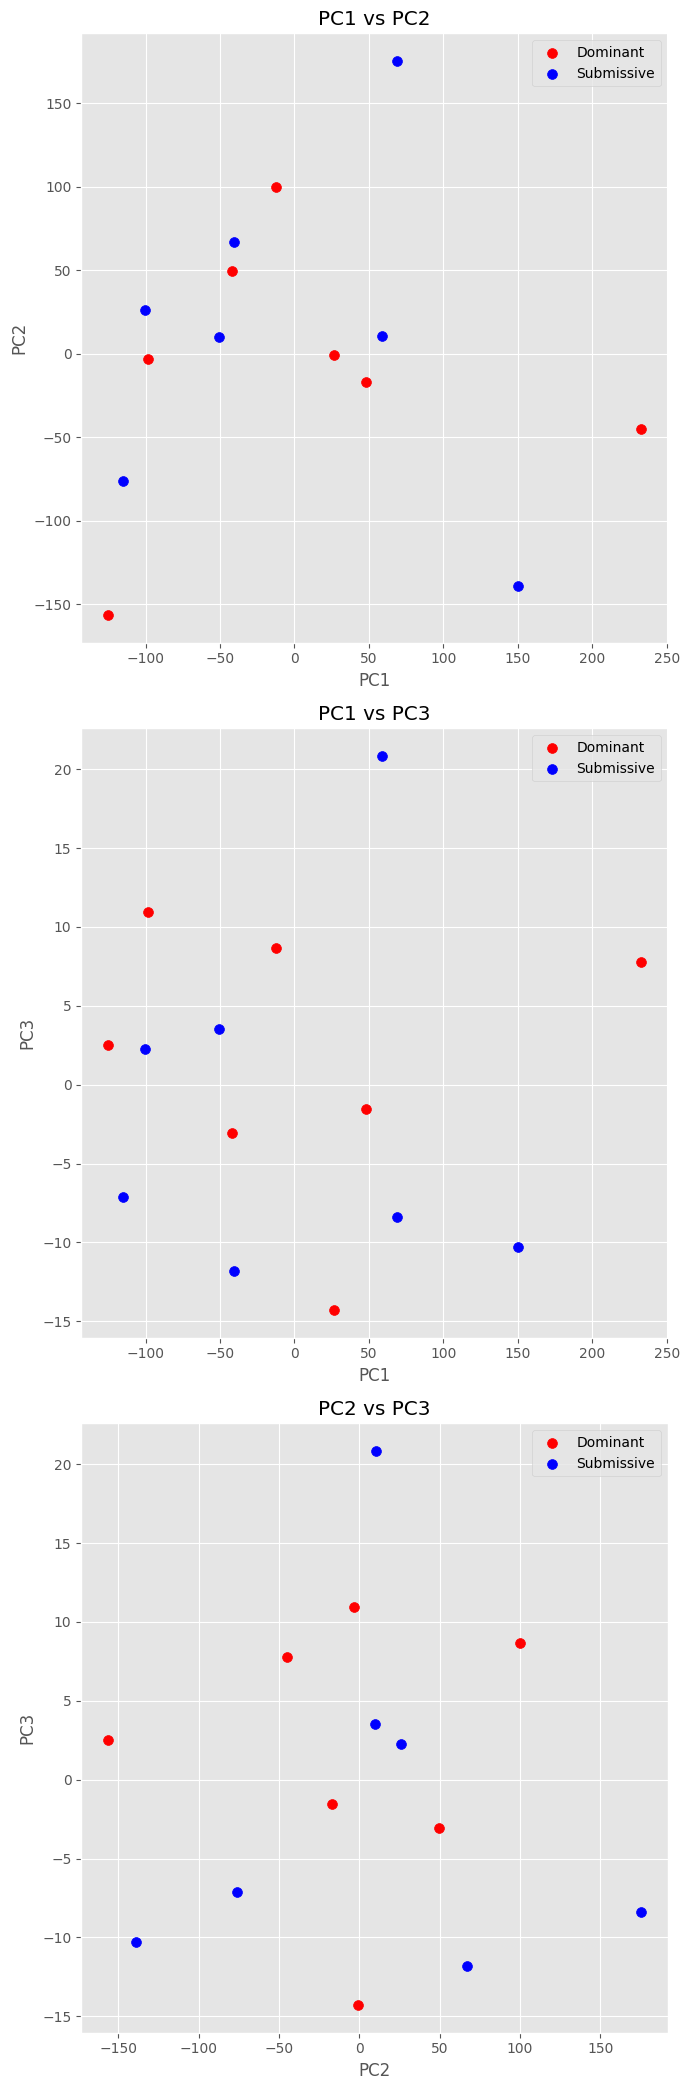

In [ ]:
df_freq['Mouse'] = df_freq['Mouse'].replace({'Mouse1': 'Dominant', 'Mouse2': 'Submissive'})

features = df_freq.drop(['Mouse', 'cage'], axis=1)
labels = df_freq['Mouse']

pca = PCA(n_components=3)  # Reduce to three dimensions
principalComponents = pca.fit_transform(features)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])

# Concatenate the labels back for plotting
finalDf = pd.concat([principalDf, labels.reset_index(drop=True)], axis=1)

# Plotting
fig, axs = plt.subplots(3, figsize=(7, 21))

colors = {'Dominant': 'r', 'Submissive': 'b'}  # Color map for the categories

# Plot for PC1 vs PC2
for mouse, color in colors.items():
    indicesToKeep = finalDf['Mouse'] == mouse
    axs[0].scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], c=color, s=50, label=mouse)
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('PC1 vs PC2')
axs[0].legend()

# Plot for PC1 vs PC3
for mouse, color in colors.items():
    indicesToKeep = finalDf['Mouse'] == mouse
    axs[1].scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC3'], c=color, s=50, label=mouse)
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC3')
axs[1].set_title('PC1 vs PC3')
axs[1].legend()

# Plot for PC2 vs PC3
for mouse, color in colors.items():
    indicesToKeep = finalDf['Mouse'] == mouse
    axs[2].scatter(finalDf.loc[indicesToKeep, 'PC2'], finalDf.loc[indicesToKeep, 'PC3'], c=color, s=50, label=mouse)
axs[2].set_xlabel('PC2')
axs[2].set_ylabel('PC3')
axs[2].set_title('PC2 vs PC3')
axs[2].legend()

plt.tight_layout()
plt.show()

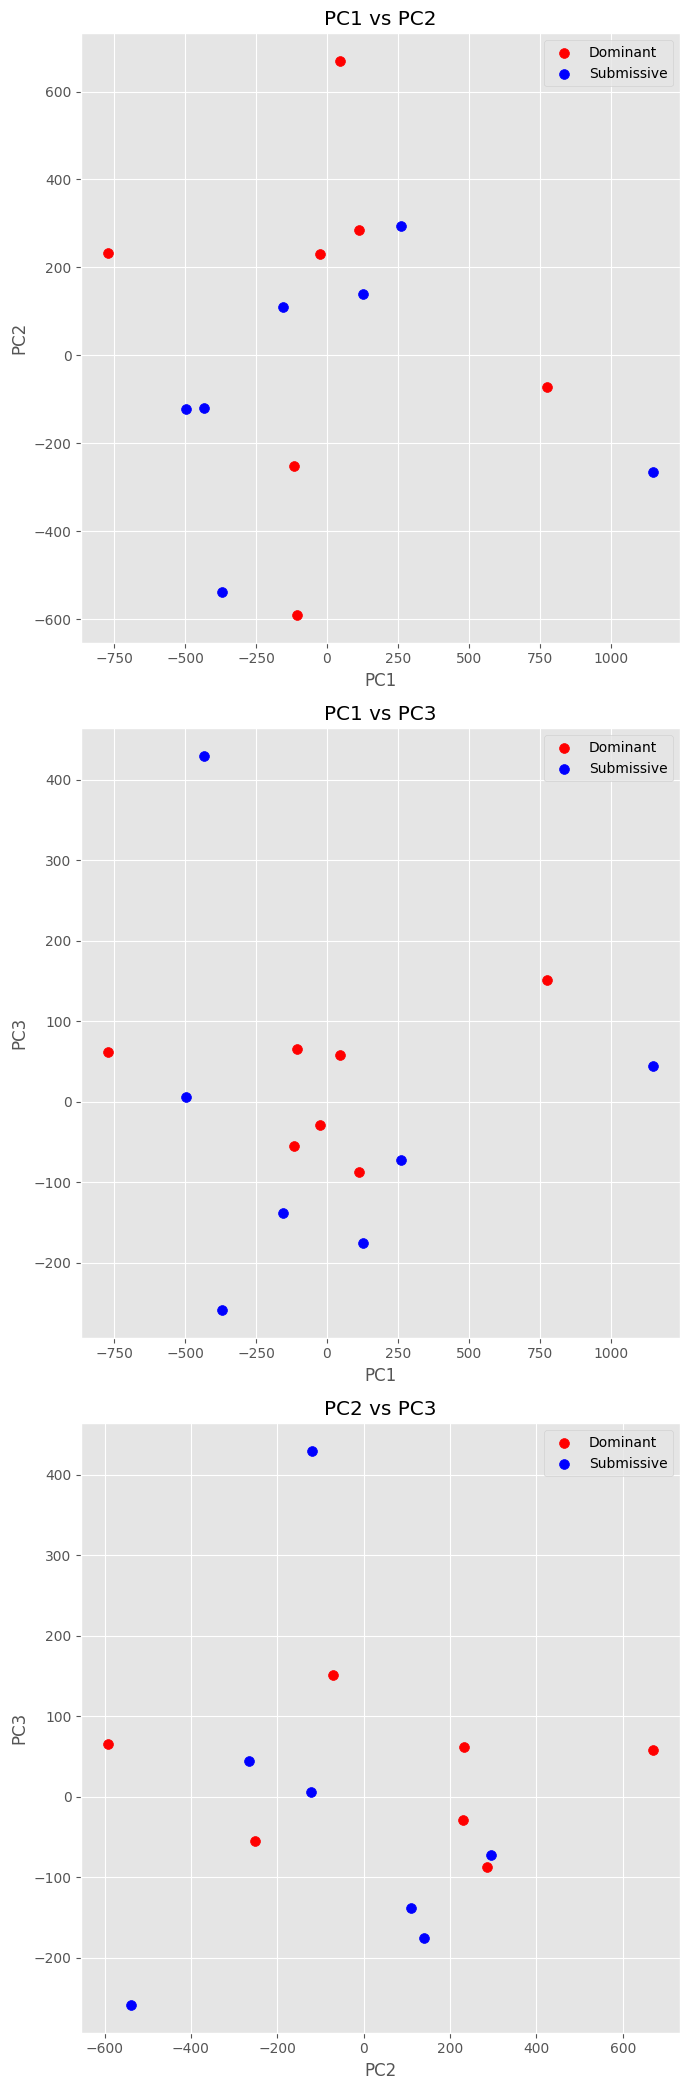

In [ ]:
df_duration['Mouse'] = df_duration['Mouse'].replace({'Mouse1': 'Dominant', 'Mouse2': 'Submissive'})

features = df_duration.drop(['Mouse', 'cage'], axis=1)
labels = df_duration['Mouse']

pca = PCA(n_components=3)  # Reduce to three dimensions
principalComponents = pca.fit_transform(features)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])

# Concatenate the labels back for plotting
finalDf = pd.concat([principalDf, labels.reset_index(drop=True)], axis=1)

# Plotting
fig, axs = plt.subplots(3, figsize=(7, 21))

colors = {'Dominant': 'r', 'Submissive': 'b'}  # Color map for the categories

# Plot for PC1 vs PC2
for mouse, color in colors.items():
    indicesToKeep = finalDf['Mouse'] == mouse
    axs[0].scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], c=color, s=50, label=mouse)
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('PC1 vs PC2')
axs[0].legend()

# Plot for PC1 vs PC3
for mouse, color in colors.items():
    indicesToKeep = finalDf['Mouse'] == mouse
    axs[1].scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC3'], c=color, s=50, label=mouse)
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC3')
axs[1].set_title('PC1 vs PC3')
axs[1].legend()

# Plot for PC2 vs PC3
for mouse, color in colors.items():
    indicesToKeep = finalDf['Mouse'] == mouse
    axs[2].scatter(finalDf.loc[indicesToKeep, 'PC2'], finalDf.loc[indicesToKeep, 'PC3'], c=color, s=50, label=mouse)
axs[2].set_xlabel('PC2')
axs[2].set_ylabel('PC3')
axs[2].set_title('PC2 vs PC3')
axs[2].legend()

plt.tight_layout()
plt.show()

AttributeError: 'NoneType' object has no attribute 'items'

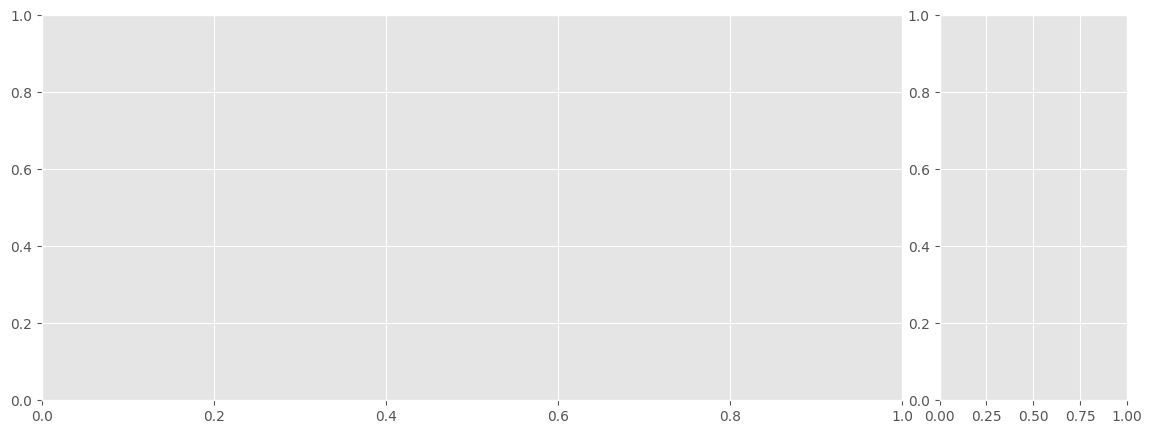

In [ ]:
fig = plt.figure(figsize=(14, 5)).subplot_mosaic(
    mosaic="""
           AAAAB
           AAAAB
           """,
)

deepof.visuals.plot_enrichment(
    deepof_mice,
    supervised_annotations=data,
    add_stats="Mann-Whitney",
    plot_proportions=True,
    ax = fig["A"],
)

deepof.visuals.plot_enrichment(
    deepof_mice,
    supervised_annotations=data,
    add_stats="Mann-Whitney",
    plot_proportions=False,
    ax = fig["B"],
)

for ax in fig:
    fig[ax].set_xticklabels(fig[ax].get_xticklabels(), rotation=45, ha='right')
    fig[ax].set_title("")
    fig[ax].set_xlabel("")

fig["A"].get_legend().remove()

plt.tight_layout()
plt.show()

In [280]:
cages = ['cageD_astromorph', 'cageA_astromorph', 'cageF_astromorph', 'cageH_astromorph', 'cageI_astromorph', 'cageJ_astromorph', 'cageK_astromorph']

# Call the function for each cage
for cage in cages:
    plot_cage_gantt(cage)

KeyError: 'Cage G'

<Figure size 1200x800 with 0 Axes>